# Useful Links

In [1]:
!pip install sympy==1.6.1

  Using cached sympy-1.6.1-py3-none-any.whl (5.8 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12


https://hepweb.ucsd.edu/ph110b/110b_notes/node31.html

https://hepweb.ucsd.edu/ph110b/110b_notes/node36.html

# Import Packages

In [2]:
import warnings
import numpy as np
import sympy as smp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
warnings.filterwarnings('ignore')    
plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams['font.size'] = 40
plt.rcParams['legend.fontsize'] = 40
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
#from matplotlib.animation import PillowWriter

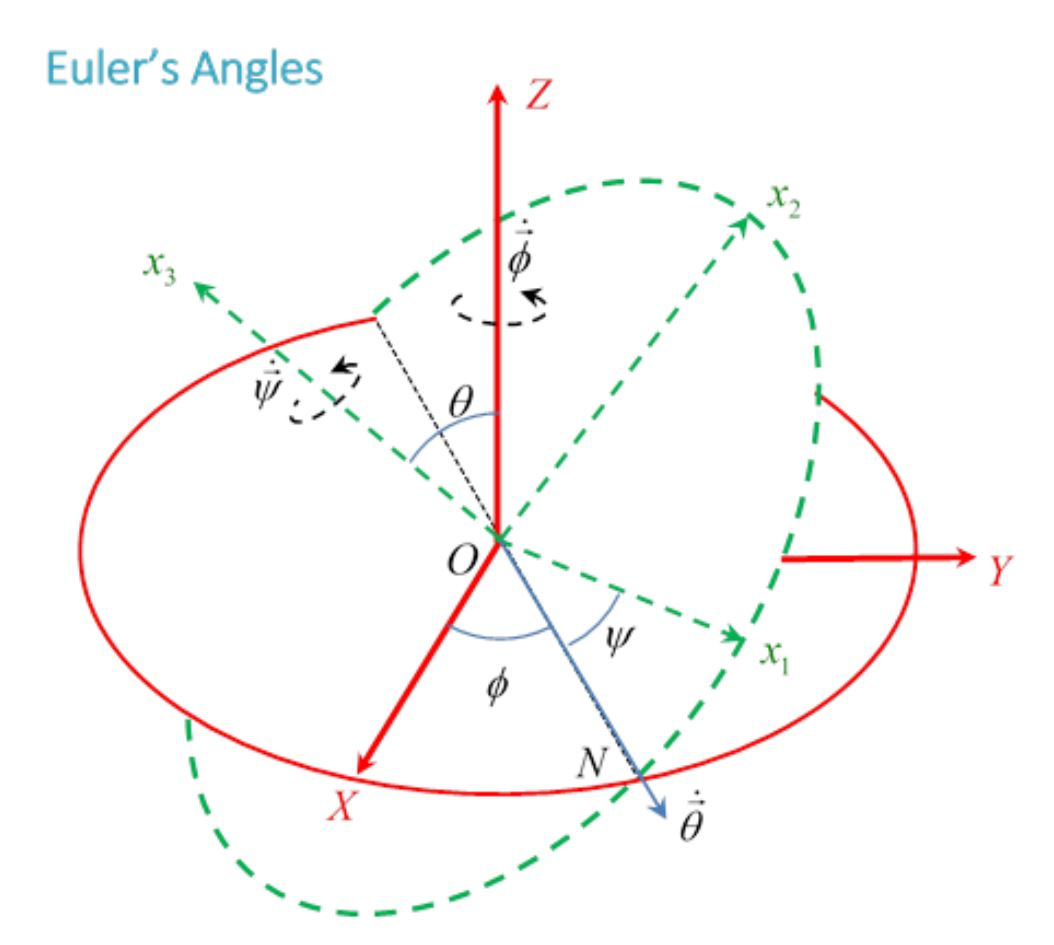

$$R=R_{\psi}R_{\theta}R_{\phi}=\begin{pmatrix} \cos\psi & \sin\psi & 0 \\ -\sin\psi & \cos\psi & 0 \\ 0 & 0 & 1  \end{pmatrix} \begin{pmatrix} 1 & 0 & 0 \\ 0 & \cos\theta & \sin\theta \\ 0 & -\sin\theta & \cos\theta  \end{pmatrix} \begin{pmatrix} \cos\phi & \sin\phi & 0 \\ -\sin\phi & \cos\phi & 0 \\ 0 & 0 & 1  \end{pmatrix}$$

Assume the top of the spinning top is pointed along $x_3$. The angular momentum vector in terms of the Euler angles $\theta$, $\phi$ and $\psi$ is

$$\vec{\omega} = \begin{bmatrix}\dot{\phi}\sin(\theta)\sin(\psi) + \dot{\theta}\cos(\psi)\\\dot{\phi}\sin(\theta)\cos(\psi) - \dot{\theta}\sin(\psi)\\ \dot{\phi}\cos(\theta) + \dot{\psi} \end{bmatrix}$$

So the kinetic energy is

$$T = \frac{1}{2}\omega^T I \omega$$ 

where $I$ is the moment of inertia tensor for the spinning top (see last video). The potential energy is given by the location of the center of mass $V = mgh\cos(\theta)$ where $h$ is the $z$ location of the center of mass. Thus the Lagrangian $\mathcal{L} = T-V$ is

$$\mathcal{L} = \frac{1}{2}\omega^T I \omega - mgh\cos(\theta)$$

Let $L$ (note: *not* the Lagrangian) be the length of the spinning top. We can turn this into a dimensionless quantity by dividing by $mL^2$

$$\frac{\mathcal{L}}{mL^2} =  \frac{1}{2}\omega^T \left(\frac{I}{mL^2}\right) \omega - \left(\frac{g}{L}\right)\left(\frac{h}{L}\right)\cos(\theta)$$

We can prime everything that is dimensionless

$$\mathcal{L}' = \frac{1}{2}\omega^T I' \omega - g'h'\cos(\theta)$$

Below, we will omit the primes, but note that everything we deal with in the code is dimensionless quantities. This works because $\mathcal{L}$ and $\mathcal{L}'$ yield the same equations of motion.

# Solve Lagranges Equation 

Define all appropriate symbols and declare appropriate functions

In [3]:
t, h, g = smp.symbols('t h g', real=True)
the, phi, psi = smp.symbols(r'\theta \phi \psi', cls=smp.Function)
the = the(t)
phi = phi(t)
psi = psi(t)
# Derivatives
the_d = smp.diff(the,t)
phi_d = smp.diff(phi,t)
psi_d = smp.diff(psi,t)
# Second derivatives
the_dd = smp.diff(the_d,t)
phi_dd = smp.diff(phi_d,t)
psi_dd = smp.diff(psi_d,t)

Transformation matrix. This matrix $R$ takes a vector in the $x_1,x_2,x_3$ coordinate system and transforms it into a vector into the $x,y,z$ coordinate system. We need this because the top of the spinning top is always at $\left<1,0,0\right>$ in the $x_1,x_2,x_3$ coordinate system, and so we rotate to get the position in the $x,y,z$ coodinate system.

In [4]:
R3 = smp.Matrix([[smp.cos(psi), -smp.sin(psi), 0],
                 [smp.sin(psi),  smp.cos(psi), 0],
                 [           0,             0, 1]])

R2 = smp.Matrix([[1,            0,             0],
                 [0, smp.cos(the), -smp.sin(the)],
                 [0, smp.sin(the),  smp.cos(the)]])

R1 = smp.Matrix([[smp.cos(phi), -smp.sin(phi), 0],
                 [smp.sin(phi),  smp.cos(phi), 0],
                 [           0,             0, 1]])

R = R1*R2*R3
R.T

Matrix([
[-sin(\phi(t))*sin(\psi(t))*cos(\theta(t)) + cos(\phi(t))*cos(\psi(t)),  sin(\phi(t))*cos(\psi(t)) + sin(\psi(t))*cos(\phi(t))*cos(\theta(t)), sin(\psi(t))*sin(\theta(t))],
[-sin(\phi(t))*cos(\psi(t))*cos(\theta(t)) - sin(\psi(t))*cos(\phi(t)), -sin(\phi(t))*sin(\psi(t)) + cos(\phi(t))*cos(\psi(t))*cos(\theta(t)), sin(\theta(t))*cos(\psi(t))],
[                                          sin(\phi(t))*sin(\theta(t)),                                          -sin(\theta(t))*cos(\phi(t)),              cos(\theta(t))]])

Get the position of the top of the spinning top as a function of time.

In [5]:
R@smp.Matrix([0,0,1])

Matrix([
[ sin(\phi(t))*sin(\theta(t))],
[-sin(\theta(t))*cos(\phi(t))],
[              cos(\theta(t))]])

Define the angular momentum vector $\omega$ in terms of the euler angles $\theta$, $\phi$ and $\omega$. 

* This is non-trivial: see http://galileoandeinstein.physics.virginia.edu/7010/CM_26_Euler_Angles.html for where these definitions come from.

In [6]:
omega = smp.Matrix([phi_d*smp.sin(the)*smp.sin(psi)+the_d*smp.cos(psi),
                    phi_d*smp.sin(the)*smp.cos(psi)-the_d*smp.sin(psi),
                    phi_d*smp.cos(the)+psi_d])
omega

Matrix([
[ sin(\psi(t))*sin(\theta(t))*Derivative(\phi(t), t) + cos(\psi(t))*Derivative(\theta(t), t)],
[-sin(\psi(t))*Derivative(\theta(t), t) + sin(\theta(t))*cos(\psi(t))*Derivative(\phi(t), t)],
[                             cos(\theta(t))*Derivative(\phi(t), t) + Derivative(\psi(t), t)]])

Define the moment of inertia tensor

In [7]:
Ixx, Iyy, Izz, Ixy, Iyz, Ixz = smp.symbols('I_{xx}, I_{yy}, I_{zz}, I_{xy}, I_{yz}, I_{xz}', real=True)
I = smp.Matrix([[Ixx,Ixy,Ixz],
                [Ixy,Iyy,Iyz],
                [Ixz,Iyz,Izz]])
I

Matrix([
[I_{xx}, I_{xy}, I_{xz}],
[I_{xy}, I_{yy}, I_{yz}],
[I_{xz}, I_{yz}, I_{zz}]])

Define the Lagrangian

In [8]:
T = smp.Rational(1,2)*omega.T.dot(I*omega).simplify()
T

-(sin(\psi(t))*Derivative(\theta(t), t) - sin(\theta(t))*cos(\psi(t))*Derivative(\phi(t), t))*(I_{xy}*(sin(\psi(t))*sin(\theta(t))*Derivative(\phi(t), t) + cos(\psi(t))*Derivative(\theta(t), t)) - I_{yy}*(sin(\psi(t))*Derivative(\theta(t), t) - sin(\theta(t))*cos(\psi(t))*Derivative(\phi(t), t)) + I_{yz}*(cos(\theta(t))*Derivative(\phi(t), t) + Derivative(\psi(t), t)))/2 + (cos(\theta(t))*Derivative(\phi(t), t) + Derivative(\psi(t), t))*(I_{xz}*(sin(\psi(t))*sin(\theta(t))*Derivative(\phi(t), t) + cos(\psi(t))*Derivative(\theta(t), t)) - I_{yz}*(sin(\psi(t))*Derivative(\theta(t), t) - sin(\theta(t))*cos(\psi(t))*Derivative(\phi(t), t)) + I_{zz}*(cos(\theta(t))*Derivative(\phi(t), t) + Derivative(\psi(t), t)))/2 + (sin(\psi(t))*sin(\theta(t))*Derivative(\phi(t), t) + cos(\psi(t))*Derivative(\theta(t), t))*(I_{xx}*(sin(\psi(t))*sin(\theta(t))*Derivative(\phi(t), t) + cos(\psi(t))*Derivative(\theta(t), t)) - I_{xy}*(sin(\psi(t))*Derivative(\theta(t), t) - sin(\theta(t))*cos(\psi(t))*Deriv

In [9]:
V = g*h*smp.cos(the)
V

g*h*cos(\theta(t))

In [10]:
L = T-V
L

-g*h*cos(\theta(t)) - (sin(\psi(t))*Derivative(\theta(t), t) - sin(\theta(t))*cos(\psi(t))*Derivative(\phi(t), t))*(I_{xy}*(sin(\psi(t))*sin(\theta(t))*Derivative(\phi(t), t) + cos(\psi(t))*Derivative(\theta(t), t)) - I_{yy}*(sin(\psi(t))*Derivative(\theta(t), t) - sin(\theta(t))*cos(\psi(t))*Derivative(\phi(t), t)) + I_{yz}*(cos(\theta(t))*Derivative(\phi(t), t) + Derivative(\psi(t), t)))/2 + (cos(\theta(t))*Derivative(\phi(t), t) + Derivative(\psi(t), t))*(I_{xz}*(sin(\psi(t))*sin(\theta(t))*Derivative(\phi(t), t) + cos(\psi(t))*Derivative(\theta(t), t)) - I_{yz}*(sin(\psi(t))*Derivative(\theta(t), t) - sin(\theta(t))*cos(\psi(t))*Derivative(\phi(t), t)) + I_{zz}*(cos(\theta(t))*Derivative(\phi(t), t) + Derivative(\psi(t), t)))/2 + (sin(\psi(t))*sin(\theta(t))*Derivative(\phi(t), t) + cos(\psi(t))*Derivative(\theta(t), t))*(I_{xx}*(sin(\psi(t))*sin(\theta(t))*Derivative(\phi(t), t) + cos(\psi(t))*Derivative(\theta(t), t)) - I_{xy}*(sin(\psi(t))*Derivative(\theta(t), t) - sin(\theta(t

Obtain Lagrange's Equations 

$$\frac{\partial L}{ \partial X} - \frac{d}{dt}\frac{\partial L}{ \partial \dot{X}}$$

for each of $X \in \left\{ \theta, \phi, \psi \right\}$

In [11]:
LE1 = (smp.diff(L, the) - smp.diff(smp.diff(L, the_d), t)).simplify()
LE1

I_{xx}*sin(2*\psi(t) - 2*\theta(t))*Derivative(\phi(t), t)**2/8 + I_{xx}*sin(2*\psi(t) - \theta(t))*Derivative(\phi(t), t)*Derivative(\psi(t), t)/2 - I_{xx}*sin(2*\psi(t) + \theta(t))*Derivative(\phi(t), t)*Derivative(\psi(t), t)/2 - I_{xx}*sin(2*\psi(t) + 2*\theta(t))*Derivative(\phi(t), t)**2/8 + I_{xx}*sin(2*\psi(t))*Derivative(\psi(t), t)*Derivative(\theta(t), t) + I_{xx}*sin(2*\theta(t))*Derivative(\phi(t), t)**2/4 - I_{xx}*cos(2*\psi(t) - \theta(t))*Derivative(\phi(t), (t, 2))/4 + I_{xx}*cos(2*\psi(t) + \theta(t))*Derivative(\phi(t), (t, 2))/4 - I_{xx}*cos(2*\psi(t))*Derivative(\theta(t), (t, 2))/2 - I_{xx}*Derivative(\theta(t), (t, 2))/2 + I_{xy}*sin(2*\psi(t) - \theta(t))*Derivative(\phi(t), (t, 2))/2 - I_{xy}*sin(2*\psi(t) + \theta(t))*Derivative(\phi(t), (t, 2))/2 + I_{xy}*sin(2*\psi(t))*Derivative(\theta(t), (t, 2)) + I_{xy}*cos(2*\psi(t) - 2*\theta(t))*Derivative(\phi(t), t)**2/4 + I_{xy}*cos(2*\psi(t) - \theta(t))*Derivative(\phi(t), t)*Derivative(\psi(t), t) - I_{xy}*cos(

In [12]:
LE2 = (smp.diff(L, phi) - smp.diff(smp.diff(L, phi_d), t)).simplify()
LE2

I_{xx}*sin(2*\psi(t) - 2*\theta(t))*Derivative(\phi(t), t)*Derivative(\psi(t), t)/4 - I_{xx}*sin(2*\psi(t) - 2*\theta(t))*Derivative(\phi(t), t)*Derivative(\theta(t), t)/4 + I_{xx}*sin(2*\psi(t) - \theta(t))*Derivative(\psi(t), t)*Derivative(\theta(t), t)/2 - I_{xx}*sin(2*\psi(t) - \theta(t))*Derivative(\theta(t), t)**2/4 - I_{xx}*sin(2*\psi(t) + \theta(t))*Derivative(\psi(t), t)*Derivative(\theta(t), t)/2 - I_{xx}*sin(2*\psi(t) + \theta(t))*Derivative(\theta(t), t)**2/4 + I_{xx}*sin(2*\psi(t) + 2*\theta(t))*Derivative(\phi(t), t)*Derivative(\psi(t), t)/4 + I_{xx}*sin(2*\psi(t) + 2*\theta(t))*Derivative(\phi(t), t)*Derivative(\theta(t), t)/4 - I_{xx}*sin(2*\psi(t))*Derivative(\phi(t), t)*Derivative(\psi(t), t)/2 - I_{xx}*sin(2*\theta(t))*Derivative(\phi(t), t)*Derivative(\theta(t), t)/2 - I_{xx}*cos(2*\psi(t) - 2*\theta(t))*Derivative(\phi(t), (t, 2))/8 - I_{xx}*cos(2*\psi(t) - \theta(t))*Derivative(\theta(t), (t, 2))/4 + I_{xx}*cos(2*\psi(t) + \theta(t))*Derivative(\theta(t), (t, 2))/

In [13]:
LE3 = (smp.diff(L, psi) - smp.diff(smp.diff(L, psi_d), t)).simplify()
LE3 

-I_{xx}*sin(2*\psi(t) - 2*\theta(t))*Derivative(\phi(t), t)**2/8 - I_{xx}*sin(2*\psi(t) - \theta(t))*Derivative(\phi(t), t)*Derivative(\theta(t), t)/2 + I_{xx}*sin(2*\psi(t) + \theta(t))*Derivative(\phi(t), t)*Derivative(\theta(t), t)/2 - I_{xx}*sin(2*\psi(t) + 2*\theta(t))*Derivative(\phi(t), t)**2/8 + I_{xx}*sin(2*\psi(t))*Derivative(\phi(t), t)**2/4 - I_{xx}*sin(2*\psi(t))*Derivative(\theta(t), t)**2/2 - I_{xy}*cos(2*\psi(t) - 2*\theta(t))*Derivative(\phi(t), t)**2/4 - I_{xy}*cos(2*\psi(t) - \theta(t))*Derivative(\phi(t), t)*Derivative(\theta(t), t) + I_{xy}*cos(2*\psi(t) + \theta(t))*Derivative(\phi(t), t)*Derivative(\theta(t), t) - I_{xy}*cos(2*\psi(t) + 2*\theta(t))*Derivative(\phi(t), t)**2/4 + I_{xy}*cos(2*\psi(t))*Derivative(\phi(t), t)**2/2 - I_{xy}*cos(2*\psi(t))*Derivative(\theta(t), t)**2 - I_{xz}*sin(\psi(t) - 2*\theta(t))*Derivative(\phi(t), t)**2/4 - I_{xz}*sin(\psi(t) - \theta(t))*Derivative(\phi(t), t)*Derivative(\theta(t), t) - I_{xz}*sin(\psi(t) + \theta(t))*Derivat

Use the three equations

$$\frac{\partial L}{ \partial X} - \frac{d}{dt}\frac{\partial L}{ \partial \dot{X}} = 0$$

for each of $X \in \left\{ \theta, \phi, \psi \right\}$ to solve for $\ddot{\theta}$, $\ddot{\phi}$ and $\ddot{\psi}$. This is possible because each of these equations is **linear** in terms of second derivatives.


In [14]:
sols = smp.solve([LE1, LE2, LE3], (the_dd, phi_dd, psi_dd), simplify=False, rational=False)

In [15]:
sols[the_dd]

(16*I_{zz}*(-16*I_{xx}*cos(2*\psi(t) - \theta(t)) + 16*I_{xx}*cos(2*\psi(t) + \theta(t)) + 32*I_{xy}*sin(2*\psi(t) - \theta(t)) - 32*I_{xy}*sin(2*\psi(t) + \theta(t)) - 32*I_{xz}*cos(\psi(t) - \theta(t)) - 32*I_{xz}*cos(\psi(t) + \theta(t)) + 16*I_{yy}*cos(2*\psi(t) - \theta(t)) - 16*I_{yy}*cos(2*\psi(t) + \theta(t)) + 32*I_{yz}*sin(\psi(t) - \theta(t)) + 32*I_{yz}*sin(\psi(t) + \theta(t))) + (-64*I_{xz}*cos(\psi(t)) + 64*I_{yz}*sin(\psi(t)))*(-8*I_{xz}*cos(\psi(t) - \theta(t)) + 8*I_{xz}*cos(\psi(t) + \theta(t)) + 8*I_{yz}*sin(\psi(t) - \theta(t)) - 8*I_{yz}*sin(\psi(t) + \theta(t)) - 16*I_{zz}*cos(\theta(t))))*(-64*I_{xx}*sin(2*\psi(t) - 2*\theta(t))*Derivative(\phi(t), t)*Derivative(\psi(t), t) + 64*I_{xx}*sin(2*\psi(t) - 2*\theta(t))*Derivative(\phi(t), t)*Derivative(\theta(t), t) - 128*I_{xx}*sin(2*\psi(t) - \theta(t))*Derivative(\psi(t), t)*Derivative(\theta(t), t) + 64*I_{xx}*sin(2*\psi(t) - \theta(t))*Derivative(\theta(t), t)**2 + 128*I_{xx}*sin(2*\psi(t) + \theta(t))*Derivativ

In [16]:
sols[phi_dd]

(-16*I_{zz}*(-32*I_{xx}*cos(2*\psi(t)) - 32*I_{xx} + 64*I_{xy}*sin(2*\psi(t)) + 32*I_{yy}*cos(2*\psi(t)) - 32*I_{yy}) - (-64*I_{xz}*cos(\psi(t)) + 64*I_{yz}*sin(\psi(t)))*(-16*I_{xz}*cos(\psi(t)) + 16*I_{yz}*sin(\psi(t))))*(-64*I_{xx}*sin(2*\psi(t) - 2*\theta(t))*Derivative(\phi(t), t)*Derivative(\psi(t), t) + 64*I_{xx}*sin(2*\psi(t) - 2*\theta(t))*Derivative(\phi(t), t)*Derivative(\theta(t), t) - 128*I_{xx}*sin(2*\psi(t) - \theta(t))*Derivative(\psi(t), t)*Derivative(\theta(t), t) + 64*I_{xx}*sin(2*\psi(t) - \theta(t))*Derivative(\theta(t), t)**2 + 128*I_{xx}*sin(2*\psi(t) + \theta(t))*Derivative(\psi(t), t)*Derivative(\theta(t), t) + 64*I_{xx}*sin(2*\psi(t) + \theta(t))*Derivative(\theta(t), t)**2 - 64*I_{xx}*sin(2*\psi(t) + 2*\theta(t))*Derivative(\phi(t), t)*Derivative(\psi(t), t) - 64*I_{xx}*sin(2*\psi(t) + 2*\theta(t))*Derivative(\phi(t), t)*Derivative(\theta(t), t) + 128*I_{xx}*sin(2*\psi(t))*Derivative(\phi(t), t)*Derivative(\psi(t), t) + 128*I_{xx}*sin(2*\theta(t))*Derivative(

In [17]:
sols[psi_dd]

((-16*I_{xz}*cos(\psi(t)) + 16*I_{yz}*sin(\psi(t)))*(-16*I_{xx}*cos(2*\psi(t) - \theta(t)) + 16*I_{xx}*cos(2*\psi(t) + \theta(t)) + 32*I_{xy}*sin(2*\psi(t) - \theta(t)) - 32*I_{xy}*sin(2*\psi(t) + \theta(t)) - 32*I_{xz}*cos(\psi(t) - \theta(t)) - 32*I_{xz}*cos(\psi(t) + \theta(t)) + 16*I_{yy}*cos(2*\psi(t) - \theta(t)) - 16*I_{yy}*cos(2*\psi(t) + \theta(t)) + 32*I_{yz}*sin(\psi(t) - \theta(t)) + 32*I_{yz}*sin(\psi(t) + \theta(t))) - (-32*I_{xx}*cos(2*\psi(t)) - 32*I_{xx} + 64*I_{xy}*sin(2*\psi(t)) + 32*I_{yy}*cos(2*\psi(t)) - 32*I_{yy})*(-8*I_{xz}*cos(\psi(t) - \theta(t)) + 8*I_{xz}*cos(\psi(t) + \theta(t)) + 8*I_{yz}*sin(\psi(t) - \theta(t)) - 8*I_{yz}*sin(\psi(t) + \theta(t)) - 16*I_{zz}*cos(\theta(t))))*(-64*I_{xx}*sin(2*\psi(t) - 2*\theta(t))*Derivative(\phi(t), t)*Derivative(\psi(t), t) + 64*I_{xx}*sin(2*\psi(t) - 2*\theta(t))*Derivative(\phi(t), t)*Derivative(\theta(t), t) - 128*I_{xx}*sin(2*\psi(t) - \theta(t))*Derivative(\psi(t), t)*Derivative(\theta(t), t) + 64*I_{xx}*sin(2*\p

We have three equations for second derivatives

$$\ddot{\theta} = f_1(\theta, \phi, \psi, \dot{\theta}, \dot{\phi}, \dot{\psi})$$
$$\ddot{\phi} = f_2(\theta, \phi, \psi, \dot{\theta}, \dot{\phi}, \dot{\psi})$$
$$\ddot{\psi} = f_3(\theta, \phi, \psi, \dot{\theta}, \dot{\phi}, \dot{\psi})$$

but python can only work with first order ODEs. Defining $z_1 = \dot{\theta}$, $z_2 = \dot{\phi}$ and $z_3 = \dot{\psi}$, we get 6 first order ODEs.

* $\dot{\theta} =z_1$
* $\dot{z_1} = f_1(\theta, \phi, \psi, z_1, z_2, z_3)$
* $\dot{\phi} =z_2$
* $\dot{z_2} = f_2(\theta, \phi, \psi, z_1, z_2, z_3)$
* $\dot{\psi} =z_3$
* $\dot{z_3} = f_3(\theta, \phi, \psi, z_1, z_2, z_3)$

Convert the sympy **symbolic** functions into typical python **numerical** functions

In [18]:
dz1dt_f = smp.lambdify((g, h, Ixx,Iyy,Izz,Ixy,Iyz,Ixz,the,phi,psi,the_d,phi_d,psi_d), sols[the_dd])
dthedt_f = smp.lambdify(the_d, the_d)

dz2dt_f = smp.lambdify((g, h, Ixx,Iyy,Izz,Ixy,Iyz,Ixz,the,phi,psi,the_d,phi_d,psi_d), sols[phi_dd])
dphidt_f = smp.lambdify(phi_d, phi_d)

dz3dt_f = smp.lambdify((g, h, Ixx,Iyy,Izz,Ixy,Iyz,Ixz,the,phi,psi,the_d,phi_d,psi_d), sols[psi_dd])
dpsidt_f = smp.lambdify(psi_d, psi_d)

Define the system of equations $S=(\theta, z_1, \phi, z_2, \psi, z_3)$ and $dS/dt = f(S,t)$

In [19]:
def dSdt(S, t):
    the, z1, phi, z2, psi, z3 = S
    return [
        dthedt_f(z1),
        dz1dt_f(g, h, Ixx,Iyy,Izz,Ixy,Iyz,Ixz,the,phi,psi,z1,z2,z3),
        dphidt_f(z2),
        dz2dt_f(g, h, Ixx,Iyy,Izz,Ixy,Iyz,Ixz,the,phi,psi,z1,z2,z3),
        dpsidt_f(z3),
        dz3dt_f(g, h, Ixx,Iyy,Izz,Ixy,Iyz,Ixz,the,phi,psi,z1,z2,z3),
    ]

# Obtain Information About Spinning Top

This is discussed more thoroughly in my previous video

In [20]:
coords = np.loadtxt('../Data/spinning_top2.txt', unpack=True, delimiter=',', dtype=int)
# Get the correct xyz axes
coords[[1, 2]] = coords[[2, 1]] 
# normalize coordinates
coords = coords/max(coords.ravel()) 
# Adjust position so z axis is in center
x_mean, y_mean, z_max = np.mean(coords[0]), np.mean(coords[1]), max(coords[2])
P0 = x_mean, y_mean, z_max
coords = coords.T - P0
coords = coords.T
# Make z positive
coords[2] = -coords[2]
x, y, z = coords

In [21]:
pd.DataFrame(coords,index=['x','y','z']).T

,x,y,z
0,0.384356,0.085009,0.445476
1,-0.385946,0.085009,0.445476
2,0.384356,0.085009,0.447796
3,-0.385946,0.085009,0.443155
4,-0.385946,0.085009,0.447796
...,...,...,...
244182,0.001525,-0.392949,0.454756
244183,-0.000795,-0.392949,0.454756
244184,-0.003115,-0.392949,0.454756
244185,-0.005435,-0.392949,0.454756


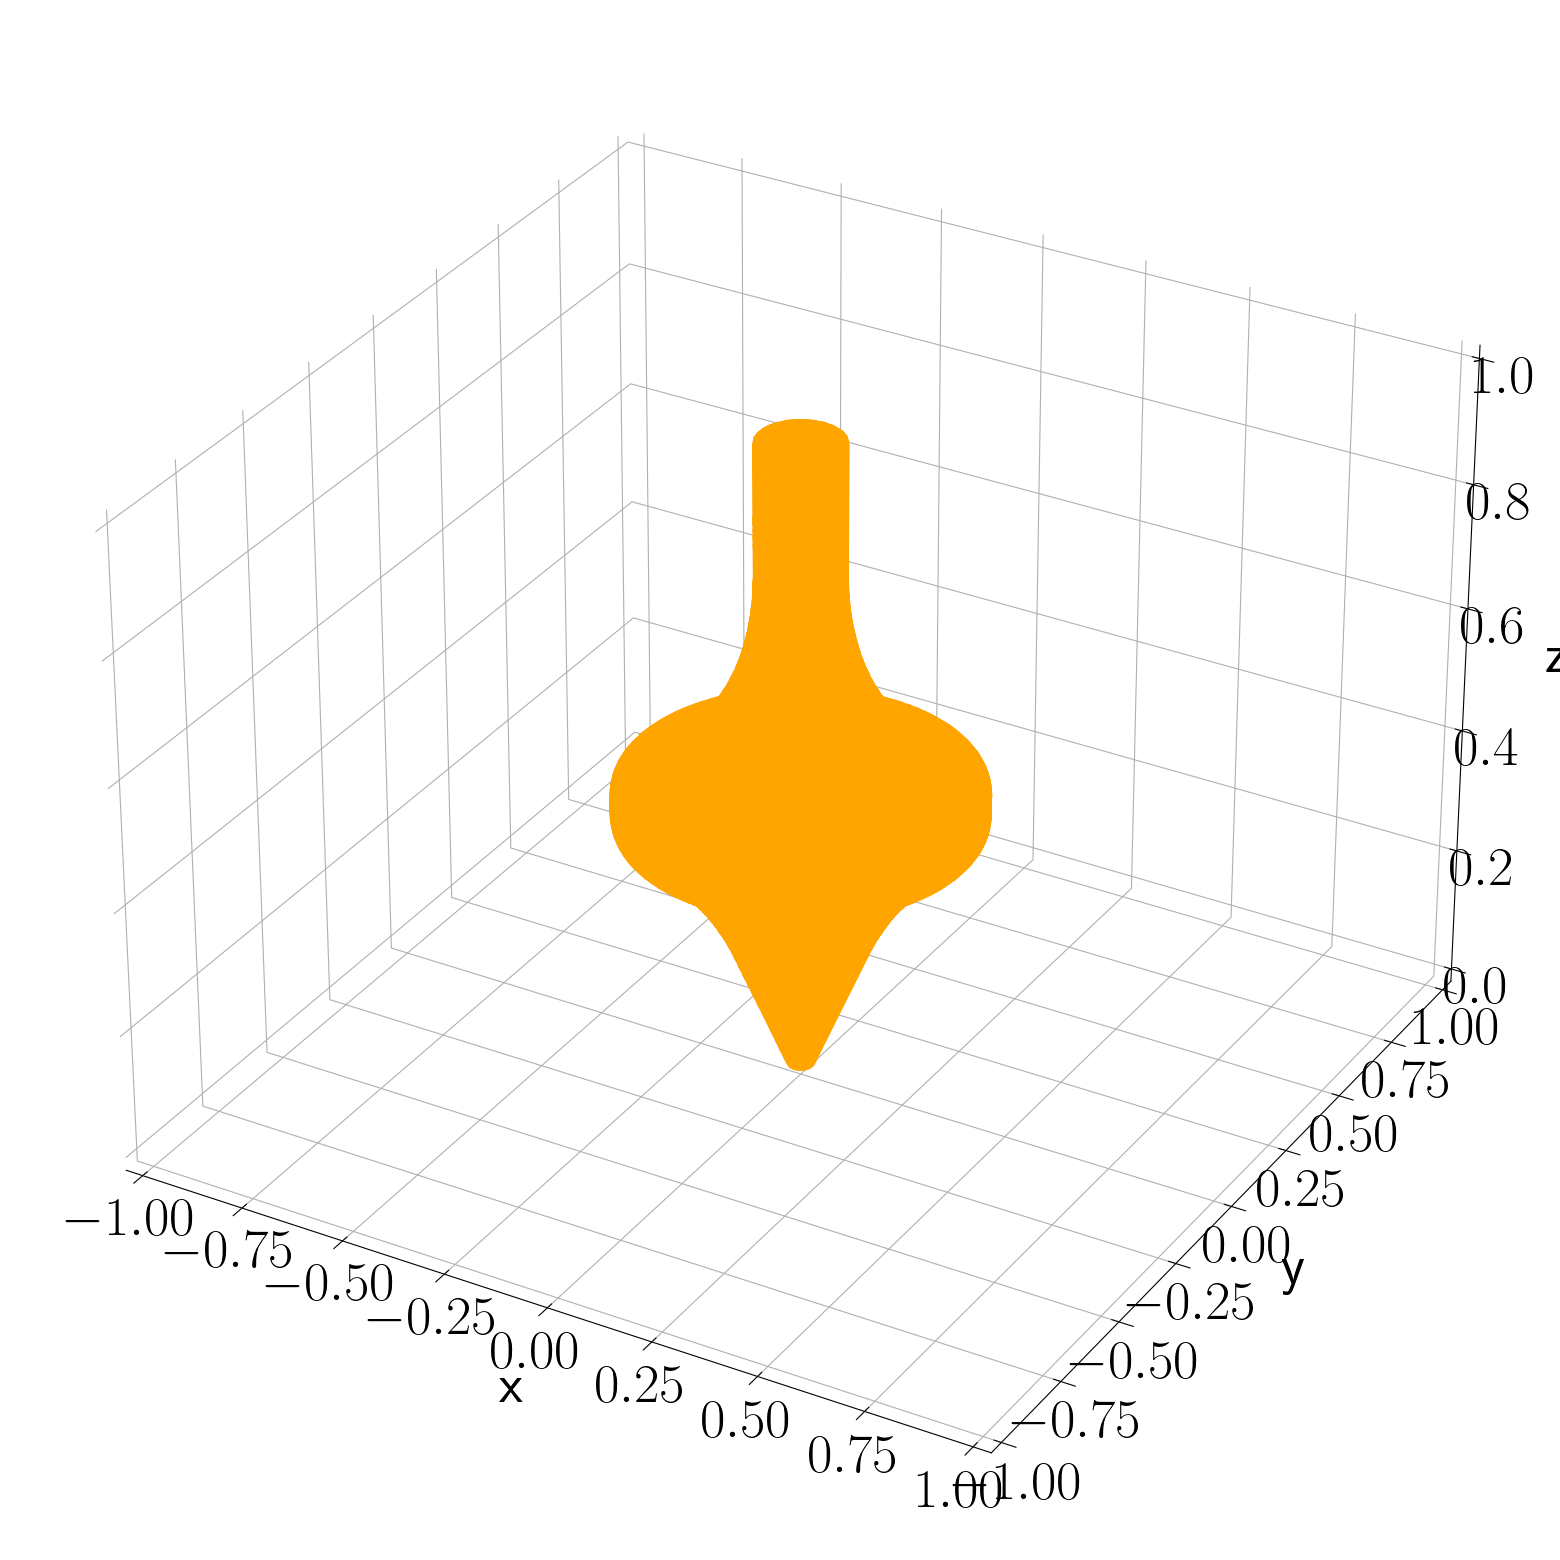

In [22]:
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
ax.scatter(x,y,z,color='orange')
ax.xaxis.set_pane_color((1,1,1,1))
ax.yaxis.set_pane_color((1,1,1,1))
ax.zaxis.set_pane_color((1,1,1,1))
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)
ax.set_xlim(-1,1)
ax.set_ylim(-1, 1)
ax.set_zlim(0,1)
plt.show()

Define the mass $m_i$ of each voxel as a function of $x,y,z$. If $m_i=1$ everywhere then all voxels weigh the same and the top is isotropic.

In [23]:
# Mass Type 1
m = np.ones(len(z))
# Mass 2
#m = z**2 + np.exp(x)

Compute the momentum of inertia tensor

In [24]:
N = coords.shape[1]
Ixx = sum(m*(coords[1]**2 + coords[2]**2))/sum(m)
Iyy = sum(m*(coords[0]**2 + coords[2]**2))/sum(m)
Izz = sum(m*(coords[0]**2 + coords[1]**2))/sum(m)
Ixy = sum(m*coords[0]*coords[1])/sum(m)
Iyz = sum(m*coords[1]*coords[2])/sum(m)
Ixz = sum(m*coords[0]*coords[2])/sum(m)
I = np.array([[Ixx, Ixy, Ixz],[Ixy, Iyy, Iyz],[Ixz, Iyz, Izz]])

In [25]:
I

array([[3.02051158e-01, 7.86146394e-07, 2.44978075e-06],
       [7.86146394e-07, 3.02053663e-01, 5.61342133e-06],
       [2.44978075e-06, 5.61342133e-06, 7.27951440e-02]])

Define appropriate quantities 

* $g'=g/L$ and gravity is $9.8~$m/s$^2$ and $L=5~$cm. 
* $h$ is the location of the center of mass in the z direction.

In [26]:
g = 9.8/0.05
h = np.sum(m*coords[2])/sum(m)

Give the mass its appropriate initial condition

* $\theta_0 = \pi/4$ (spinning top is slightly tipped)
* $\dot{\theta_0}=0$ (no tipping velocity)
* $\phi_0 = 0$ (this is arbitrary so just set equal to zero)
* $\dot{\phi_0}=10$ (slight initial movement in this direction)
* $\psi_0 = 0$ (arbitrary)
* $\dot{\psi_0}=120\pi$ (spinning top is spinning fast)

and then solve differential equation between $t=0$ to $t=2$ seconds.

In [27]:
t = np.linspace(0, 2, 10000)
# Initial Condition 1
ans = odeint(dSdt, y0=[np.pi/4, 0, 0, 10, 0, 2*np.pi*60], t=t)

In [28]:
pd.DataFrame(ans.T,index=['$\theta_o$','$\dot\theta_o$','$\phi_o$','$\dot\phi_o$','$\psi_o$','$\dot\psi_o$'])

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
$\theta_o$,0.785398,0.785390,0.785367,0.785329,0.785275,0.785206,0.785121,0.785021,0.784906,0.784776,...,0.771539,0.772152,0.772753,0.773341,0.773917,0.774481,0.775032,0.775569,0.776094,0.776606
$\dot\theta_o$,0.000000,-0.077009,-0.153980,-0.230896,-0.307742,-0.384500,-0.461154,-0.537690,-0.614091,-0.690340,...,3.093365,3.033487,2.972737,2.911134,2.848700,2.785453,2.721417,2.656611,2.591058,2.524780
$\phi_o$,0.000000,0.002000,0.004000,0.005999,0.007997,0.009993,0.011988,0.013981,0.015971,0.017959,...,6.728127,6.729824,6.731535,6.733260,6.734998,6.736750,6.738514,6.740291,6.742080,6.743881
$\dot\phi_o$,10.000000,9.998834,9.996021,9.991563,9.985462,9.977720,9.968338,9.957318,9.944661,9.930367,...,8.447780,8.519174,8.589021,8.657305,8.724011,8.789125,8.852631,8.914517,8.974770,9.033378
$\psi_o$,0.000000,0.075406,0.150812,0.226218,0.301626,0.377034,0.452443,0.527854,0.603266,0.678679,...,762.683026,762.758630,762.834225,762.909810,762.985387,763.060955,763.136514,763.212065,763.287608,763.363143
$\dot\psi_o$,376.991118,376.991892,376.993720,376.996602,377.000538,377.005525,377.011565,377.018656,377.026800,377.035996,...,378.006265,377.958726,377.912285,377.866950,377.822726,377.779620,377.737637,377.696781,377.657058,377.618471


Get solutions for euler angles and top of spinning top.

In [29]:
the_t = ans.T[0]
phi_t = ans.T[2]
psi_t = ans.T[4]
x_t = np.sin(phi_t)*np.sin(the_t)
y_t = -np.cos(phi_t)*np.sin(the_t)
z_t = np.cos(the_t)

Plot $\theta$ (tip of spinning top) as function of time

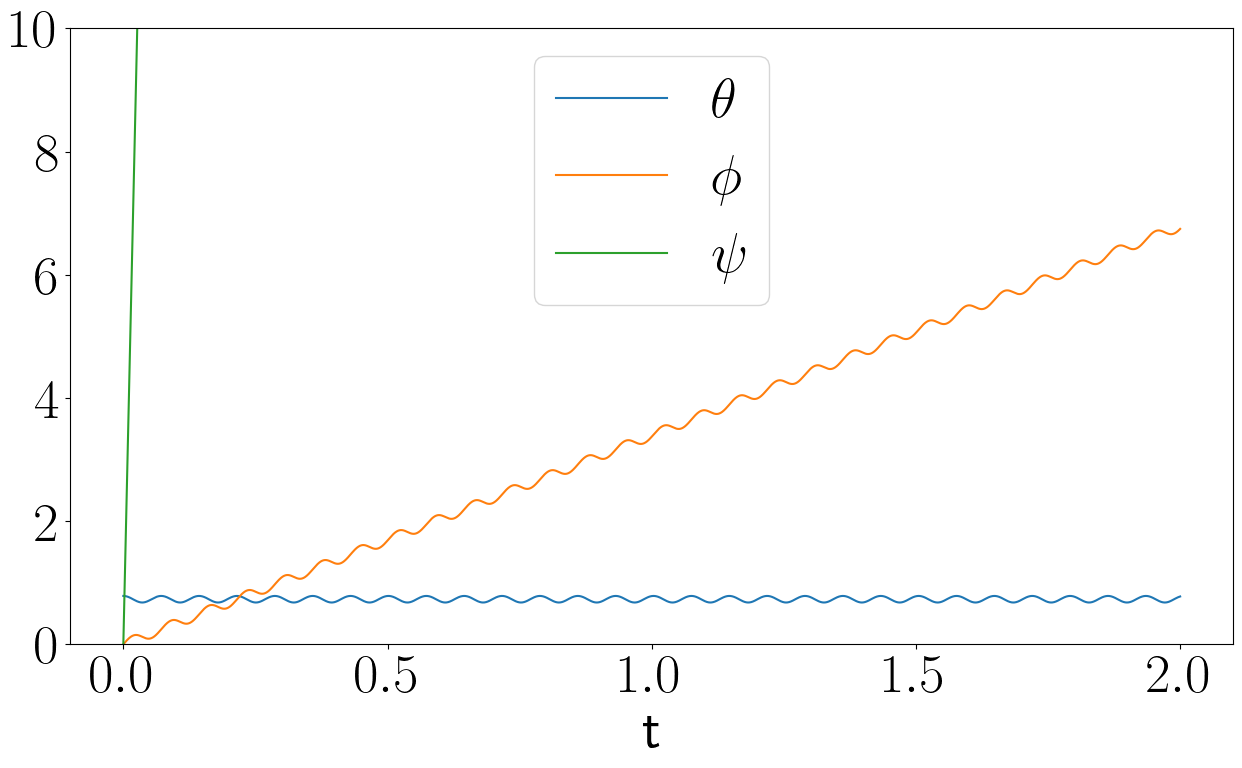

In [30]:
plt.plot(t,the_t,label=r'$\theta$')
plt.plot(t,phi_t,label=r'$\phi$')
plt.plot(t,psi_t,label=r'$\psi$')
plt.xlabel('t')
plt.ylim(0,10)
plt.legend()
plt.show()

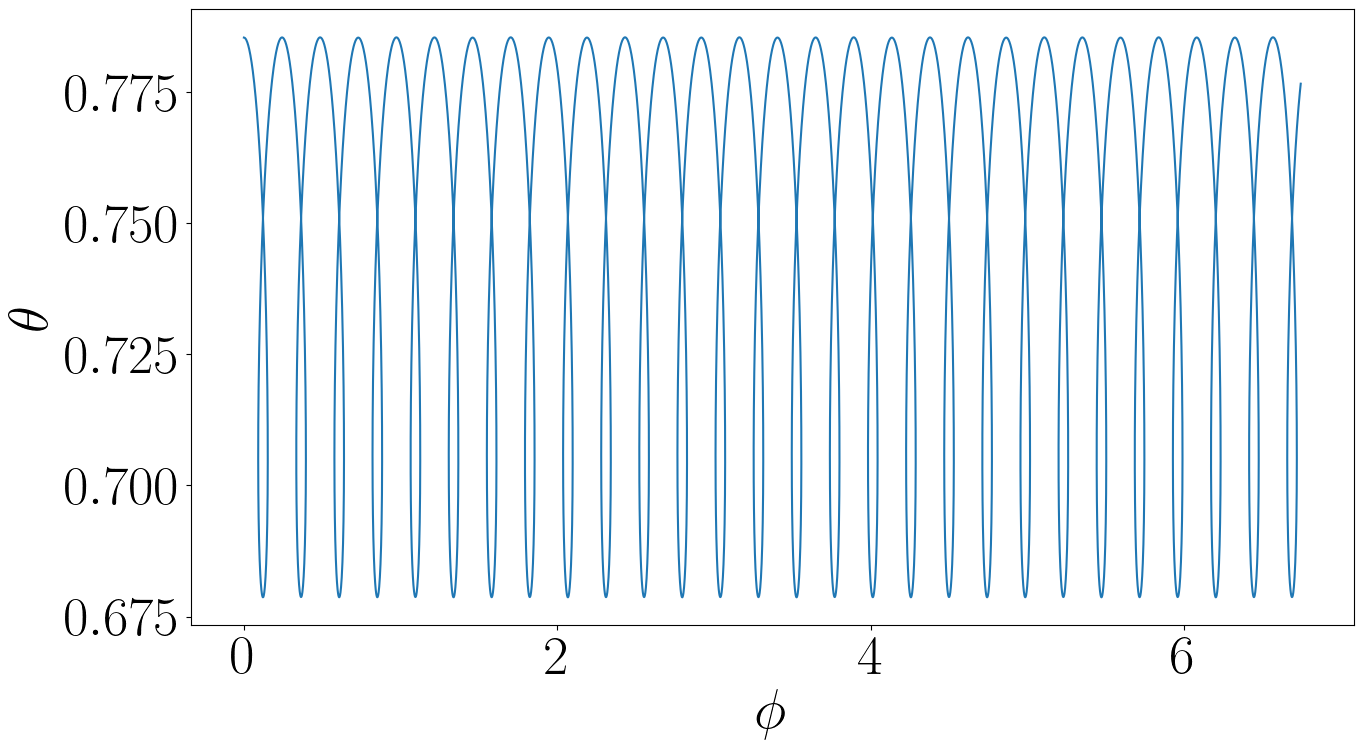

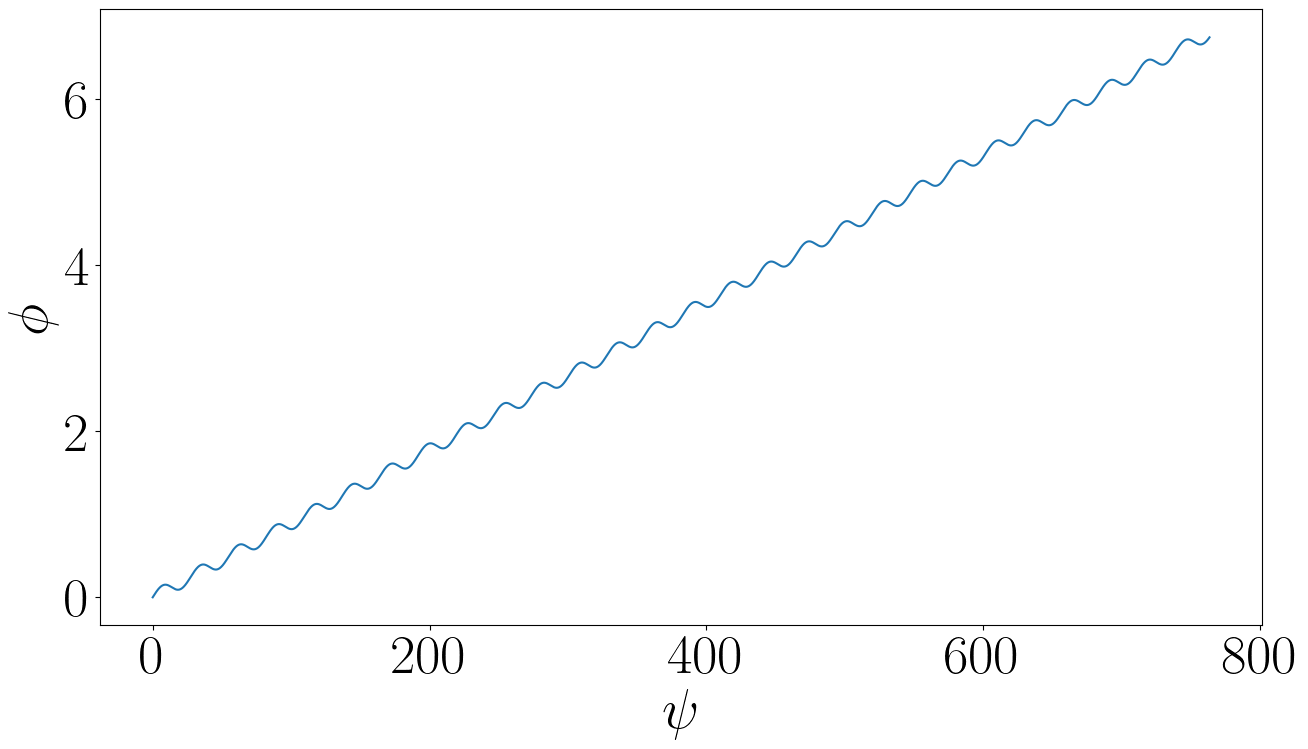

Text(0, 0.5, '$\\theta$')

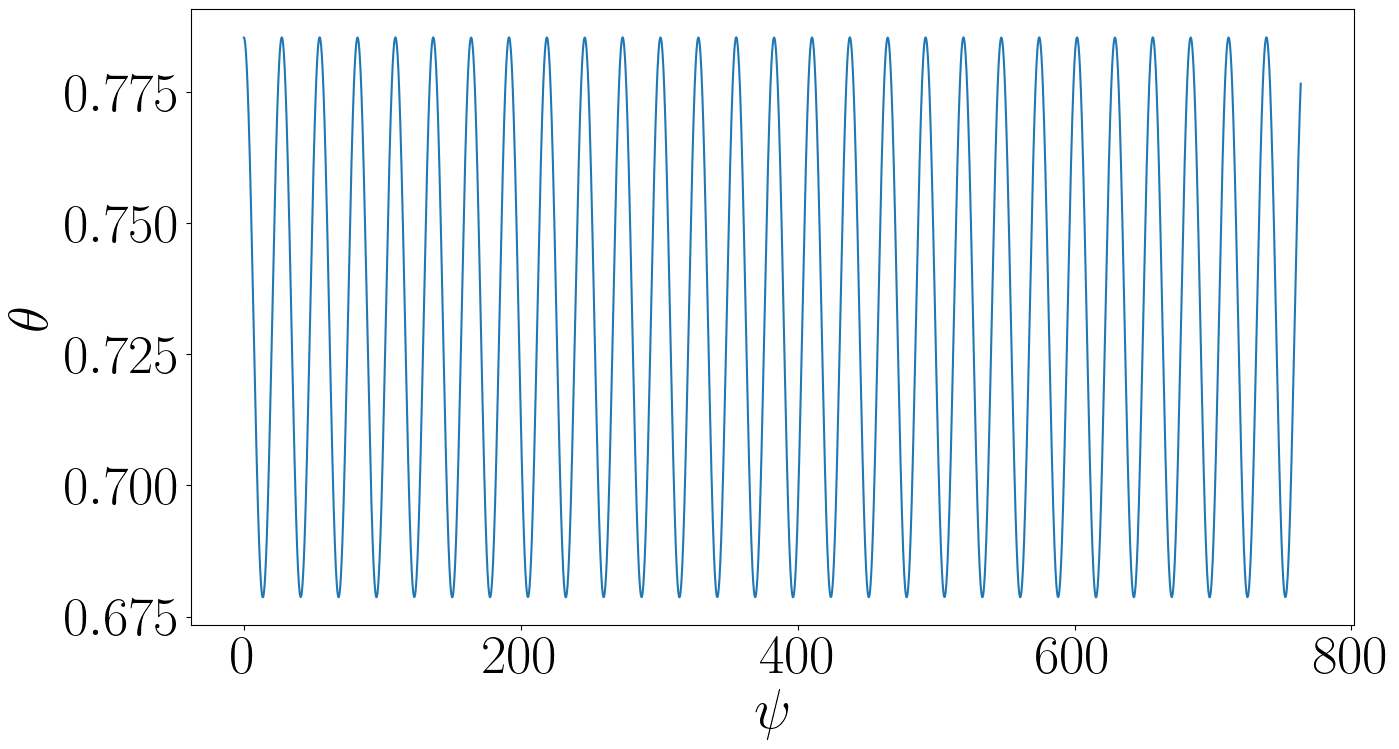

In [31]:
plt.plot(phi_t,the_t)
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\theta$')
plt.show()
plt.plot(psi_t,phi_t)
plt.xlabel(r'$\psi$')
plt.ylabel(r'$\phi$')
plt.show()
plt.plot(psi_t,the_t)
plt.xlabel(r'$\psi$')
plt.ylabel(r'$\theta$')

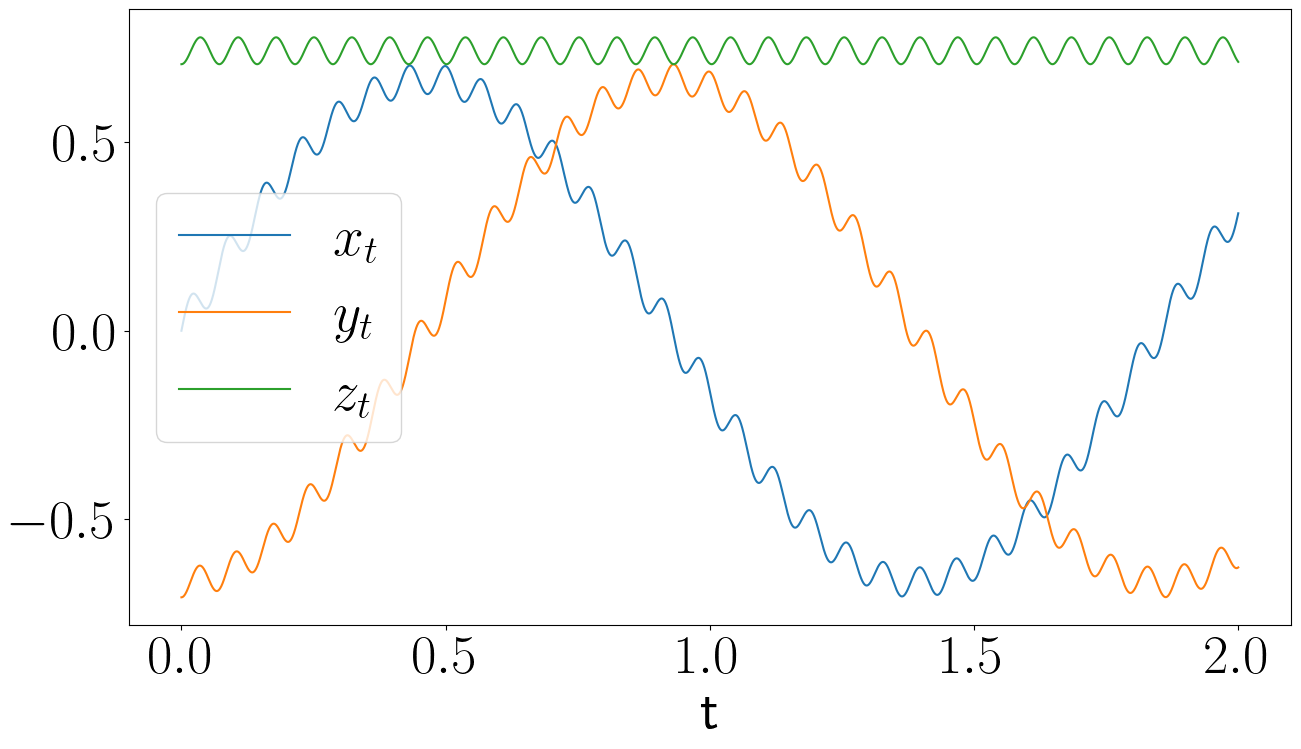

In [32]:
plt.plot(t,x_t,label=r'$x_t$')
plt.plot(t,y_t,label=r'$y_t$')
plt.plot(t,z_t,label=r'$z_t$')
plt.xlabel('t')
plt.legend()
plt.show()

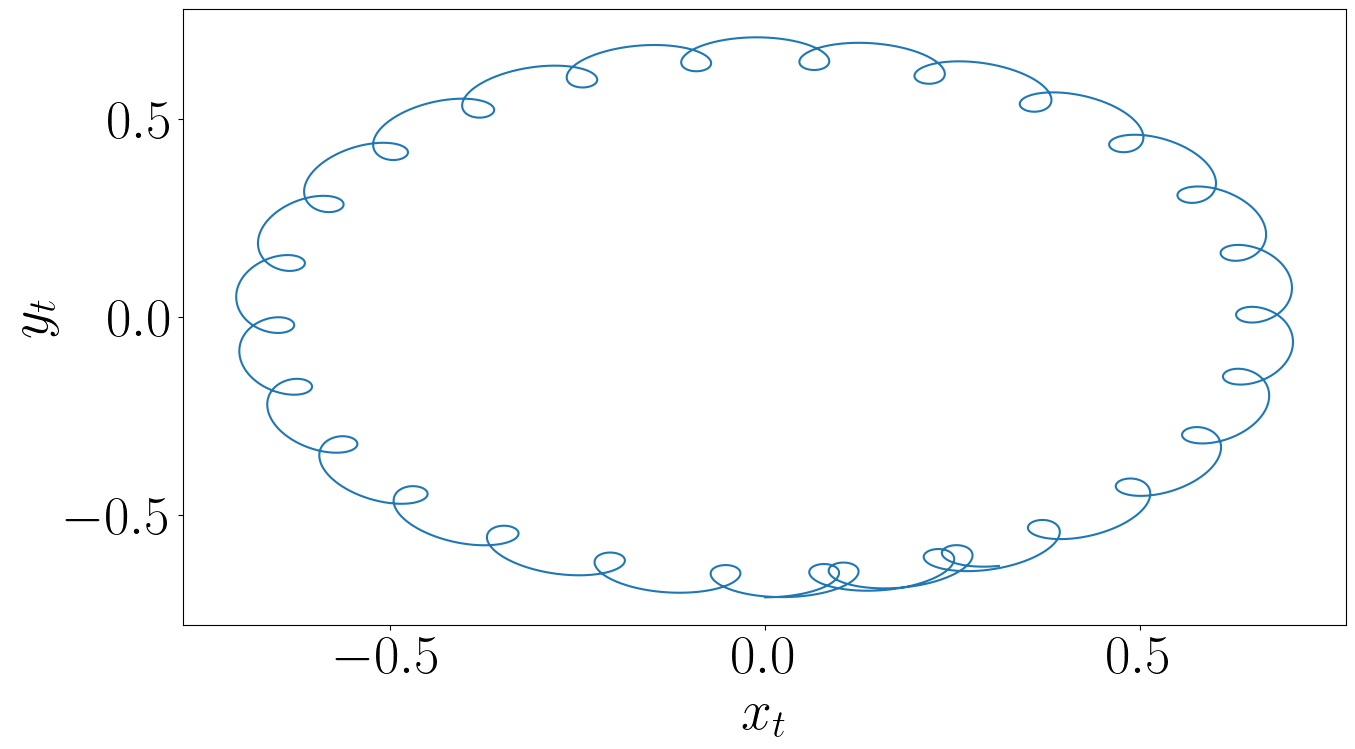

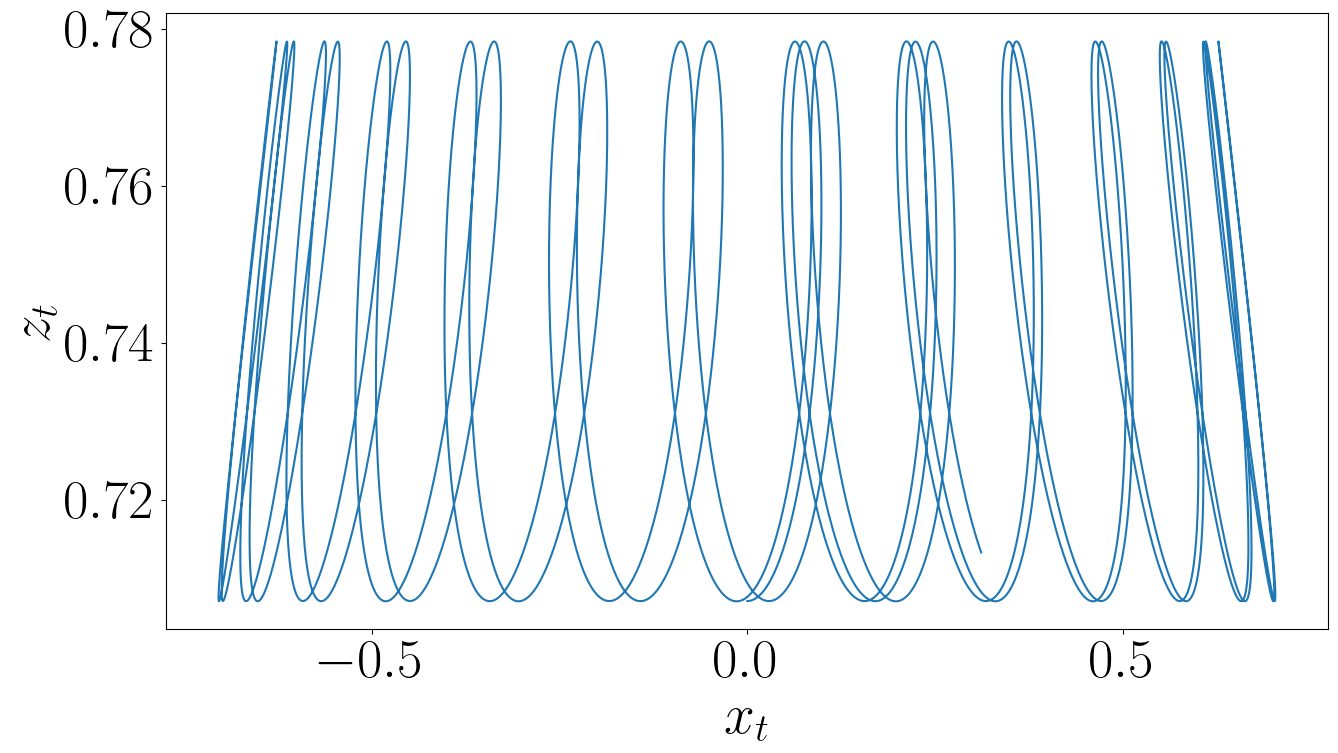

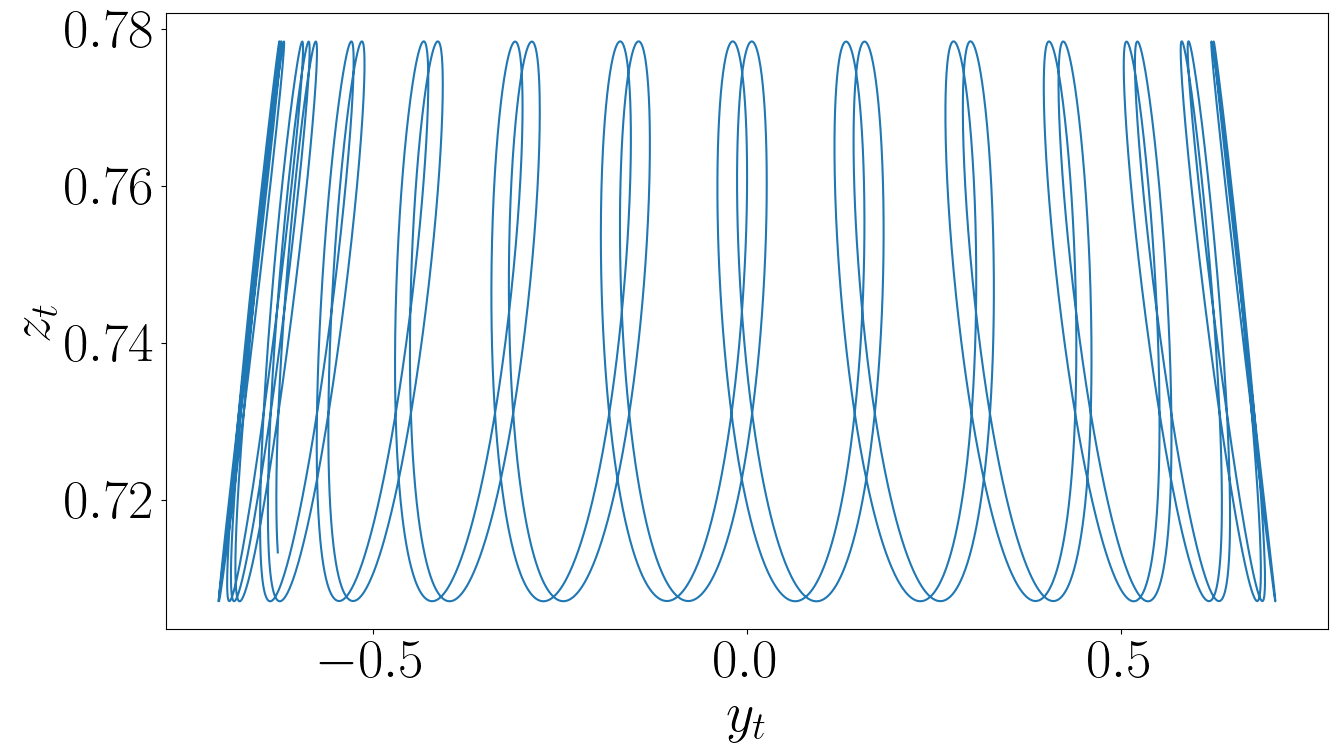

In [33]:
plt.plot(x_t,y_t)
plt.xlabel(r'$x_t$')
plt.ylabel(r'$y_t$')
plt.show()
plt.plot(x_t,z_t)
plt.xlabel(r'$x_t$')
plt.ylabel(r'$z_t$')
plt.show()
plt.plot(y_t,z_t)
plt.xlabel(r'$y_t$')
plt.ylabel(r'$z_t$')
plt.show()

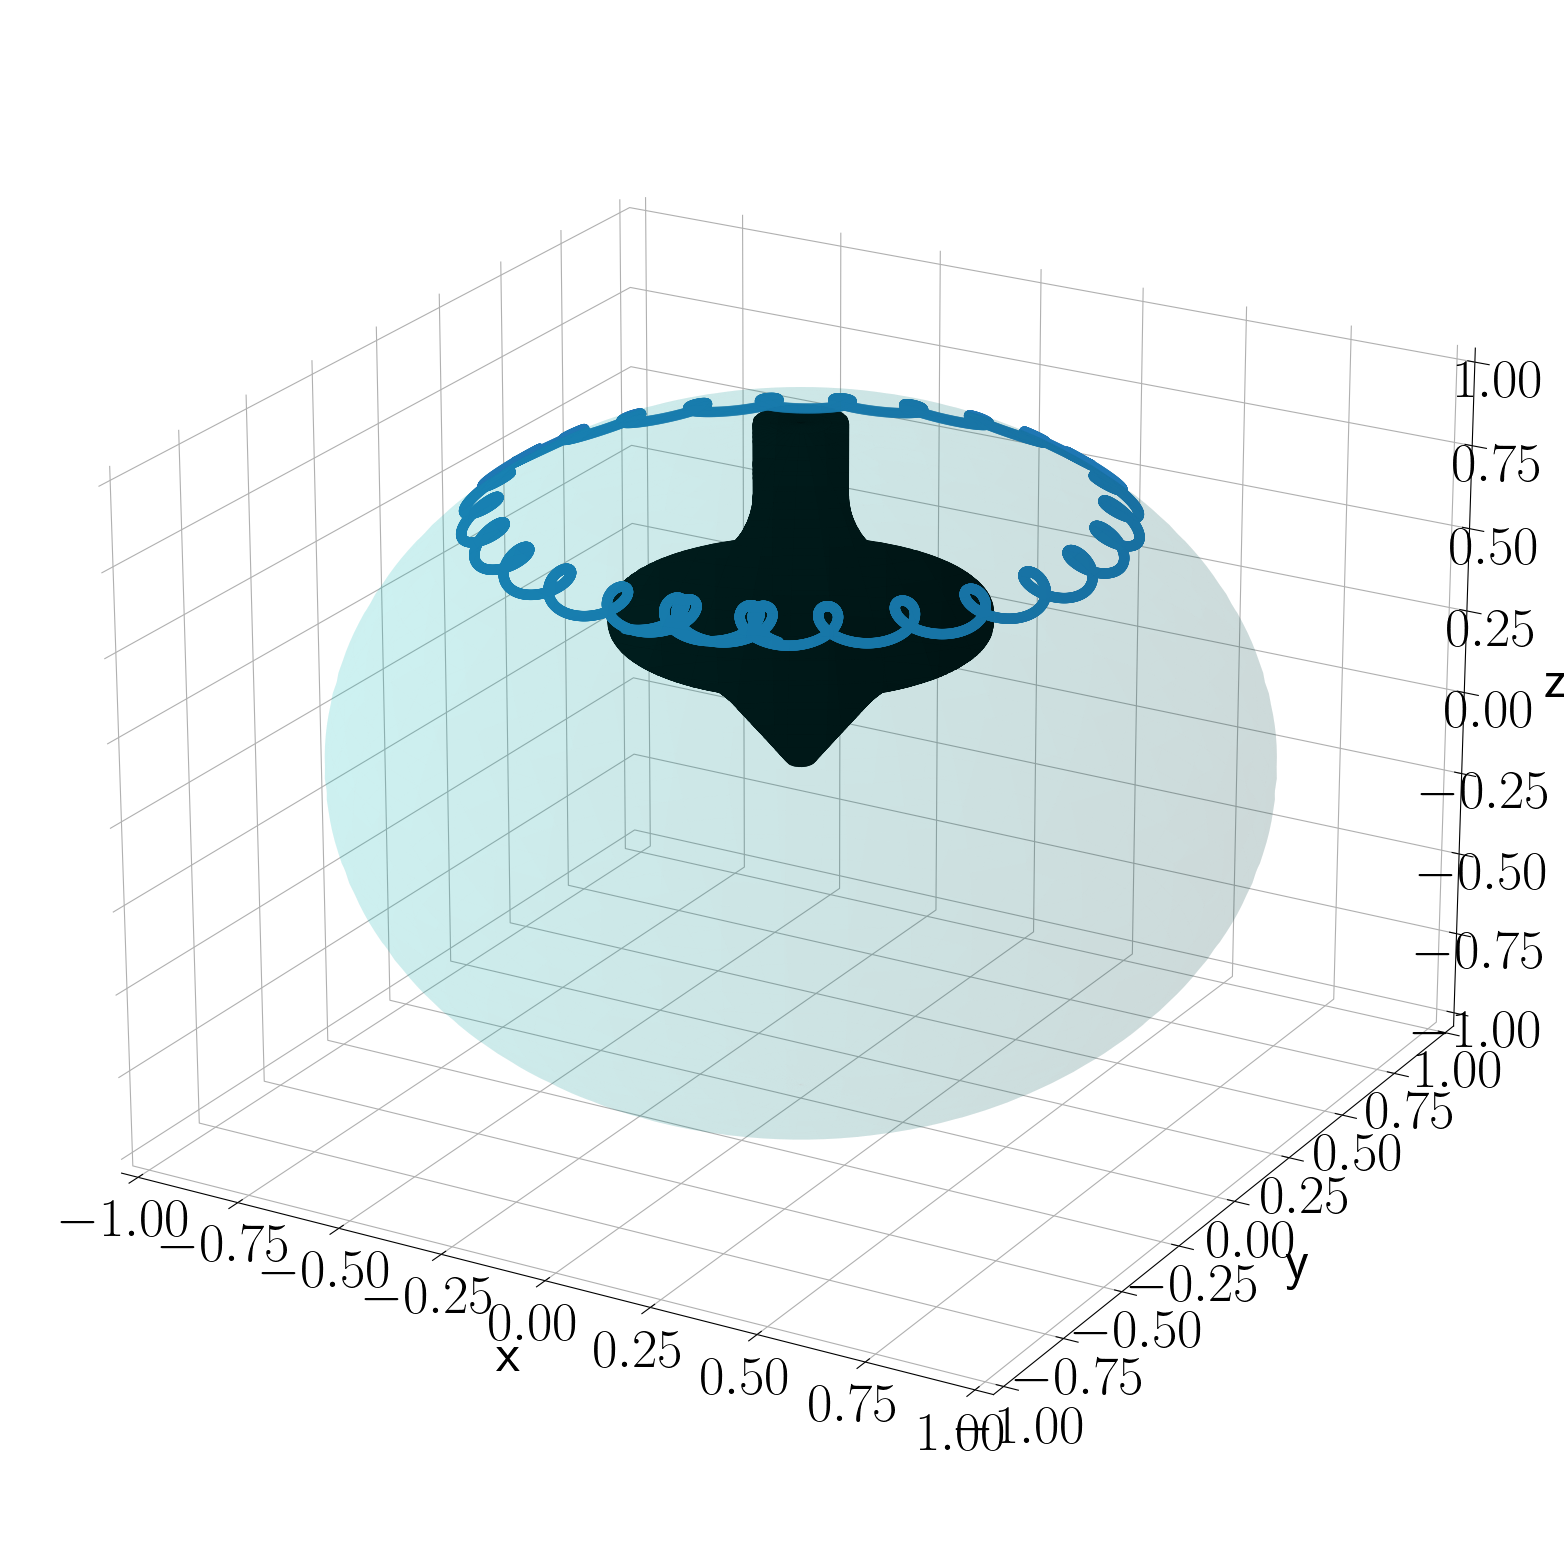

In [34]:
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')


ax.scatter(x_t,y_t,z_t,lw=3)
ax.scatter(x,y,z,color='k')
ax.xaxis.set_pane_color((1,1,1,1))
ax.yaxis.set_pane_color((1,1,1,1))
ax.zaxis.set_pane_color((1,1,1,1))
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)
ax.set_xlim(-1,1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1,1)

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x1 = 1 * np.outer(np.cos(u), np.sin(v))
y1 = 1 * np.outer(np.sin(u), np.sin(v))
z1 = 1 * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x1, y1, z1, color='c', linewidth=0, alpha=0.1)
ax.view_init(elev=22.)    
plt.show()